1/ Optimisation des fonctions d'activation du MLP classifier

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import re
import mlflow
from sklearn.model_selection import train_test_split


BASE_DIR = Path(r"C:/Users/coach/Desktop/datascientest/OpenClassrooms/Projects_MLops/Projet_1_initialisation_MLops")
DATA_RAW = BASE_DIR / "data/raw"
DATA_PROC = BASE_DIR / "data" / "proceed"
DATA_PATH = DATA_PROC / "homecredit_features.csv"
df = pd.read_csv(DATA_PATH, low_memory=False)
print(df.shape)
#print(df.head())

train_df = df[df["TARGET"].notna()]
train_autoML = train_df.drop(columns=["SK_ID_CURR"])
X = train_df.drop(columns=["TARGET", "SK_ID_CURR"])
X = X.replace([np.inf, -np.inf], np.nan)
imputer = SimpleImputer(strategy="median") #remplace les valeurs manquantes par la médiane de chaque colonne
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
y = train_df["TARGET"]
print(X.shape, y.shape)
print(y.value_counts(normalize=True)) #desequilibre des classes 0 (92%) et 1(8%)

#reduire la taille des donnees pour test rapide en conservant repartition des classes
#X = X.sample(n=10000, random_state=42)
#y = y.loc[X.index]
#print(X.shape, y.shape)  

(356251, 276)
(307507, 274) (307507,)
TARGET
0.0    0.91927
1.0    0.08073
Name: proportion, dtype: float64


In [8]:
# metrique cout metier
def business_cost(y_true, y_pred, fn_cost=10, fp_cost=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn * fn_cost + fp * fp_cost

# meilleur seuil
def find_best_threshold(y_true, y_proba):
    thresholds = np.arange(0.05, 0.95, 0.05)
    costs = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        cost = business_cost(y_true, y_pred)
        costs.append(cost)
    best_idx = np.argmin(costs)
    return thresholds[best_idx], costs


2/ Pipeline d'entrainement du baseline MLP classifier

In [9]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        max_iter=1000,
        random_state=42,
        early_stopping=True,
    ))
])

#   hyperparametres a tester pour le MLP
param_grid_mlp = {
    
    "mlp__activation": [
        "relu",
        "tanh",
        "logistic",
        "identity"
    ],
    
    "mlp__hidden_layer_sizes": [
        (50,),
        (100,),
        (100,50),
        (200,100)
    ],
    
    "mlp__alpha": [
        1e-4,
        1e-3,
        1e-2
    ],
    
    "mlp__learning_rate_init": [
        0.001,
        0.01
    ]
}

business_scorer = make_scorer(
    business_cost,
    greater_is_better=False  # car on minimise
)

mlp_grid = GridSearchCV(
    mlp_pipeline,
    param_grid_mlp,
    scoring=business_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)



3/ Entrainement Modele et fine tuning avec GridSearchCV

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params:
{'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate_init': 0.001}
Best AUC: -38934.0
Meilleurse fonction activation: tanh


<Axes: title={'center': 'Impact des Activations (MLP)'}, xlabel='param_mlp__activation'>

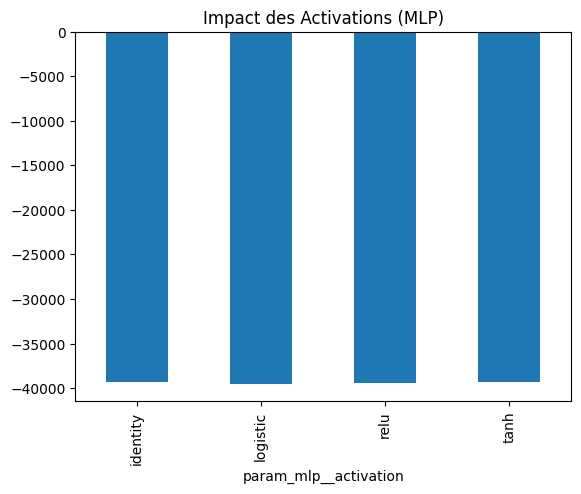

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
mlp_grid.fit(X_train, y_train)

print("Best params:")
print(mlp_grid.best_params_)

print("Best AUC:", mlp_grid.best_score_)
best_activation = mlp_grid.best_params_["mlp__activation"]
print("Meilleurse fonction activation:", best_activation)

results = pd.DataFrame(mlp_grid.cv_results_)
activation_perf = results.groupby("param_mlp__activation")["mean_test_score"].mean()
activation_perf.plot(kind="bar",title="Impact des Activations (MLP)")
